# First Expiremnt - Transfer learning from VGG16


## summery

In this test we'll set the momentum to 0 to see the effect

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])

image_size = (128,128)
batch_size = 10

training_data_dir = r'C:\Users\hayit\Developement\School\ML\Project\Data'
validation_data_dir = r'C:\Users\hayit\Developement\School\ML\Project\Test'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")


Found 33446 images belonging to 100 classes.
Found 5956 images belonging to 100 classes.


We will show the images to make sure that the loading went well

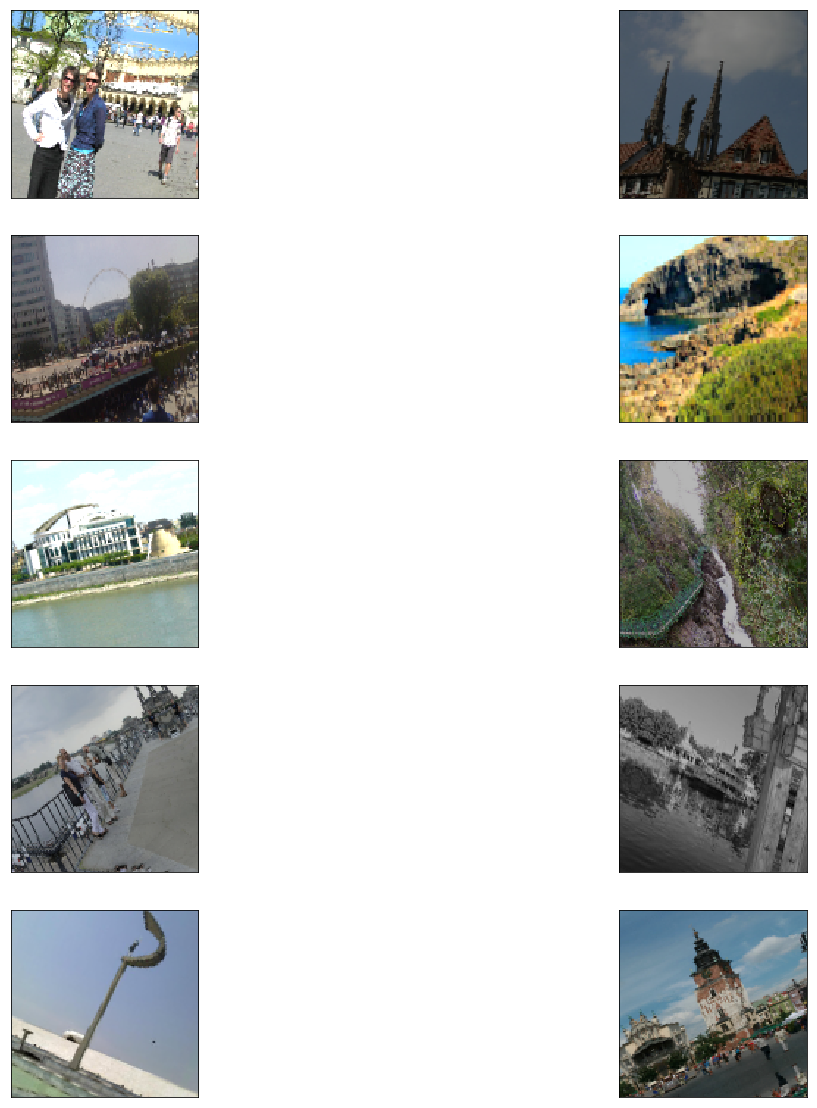

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

## Transfer learning from VGG16 model

In [3]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

amountOfClasses = 100;

base_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_size[0], image_size[1], 3))

for layer in base_model.layers[:17]:
    layer.trainable = False

## Adding the dense layers

In [4]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x) 
x=Dense(512,activation='relu')(x) 
preds=Dense(amountOfClasses,activation='softmax')(x) 

final_model=Model(inputs=base_model.input, outputs=preds)
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

## Configure loss function and optimizer

In [5]:
final_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001), metrics=["accuracy"])

## Step Size

In [6]:
step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

3344


## Creating Loss and Accuracy history callbacks

In [7]:
class LossAccHisotry(Callback):
    def on_train_begin(self,logs={}):
        self.loss_history = []
        self.accuracy_history = []
        self.val_loss_history = []
        self.val_accuracy_history = []
        
    #def on_batch_end(self,batch, logs={}):
        #self.loss_history.append(logs.get('loss'))
        #self.accuracy_history.append(logs.get('acc'))
        
    def on_epoch_end(self, epoch, logs={}):
        self.val_loss_history.append(logs.get('val_loss'))
        self.val_accuracy_history.append(logs.get('val_acc'))
        self.loss_history.append(logs.get('loss'))
        self.accuracy_history.append(logs.get('acc'))
    
history = LossAccHisotry()

## Ignoring images with a bad format

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Setting the network saving time periods

In order to save the model wieghts, we define checkpoint callback that will save the best weights which will be messured by the validation accuracy.

In [9]:
import time

networkfileName = "VGG16_exp3_2_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

## Training the model

In [10]:
NumberOfEpochs = 10

final_model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=NumberOfEpochs,
                   callbacks = [history, checkpoint])

Epoch 1/10


C:\Users\hayit\Developement\Anaconda\envs\py36\lib\site-packages\PIL\Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


3343/3344 [============================>.] - ETA: 0s - loss: 3.6780 - acc: 0.2459

C:\Users\hayit\Developement\Anaconda\envs\py36\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3300917248 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\hayit\Developement\Anaconda\envs\py36\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5898240 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\hayit\Developement\Anaconda\envs\py36\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4294901760 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\hayit\Developement\Anaconda\envs\py36\lib\site-packages\PIL\TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 589824 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
C:\Users\hayit\


Epoch 00001: val_acc improved from -inf to 0.36350, saving model to VGG16_exp3_2_1551732685.h5
3344/3344 [==============================] - 673s 201ms/step - loss: 3.6780 - acc: 0.2459 - val_loss: 2.9301 - val_acc: 0.3635
Epoch 2/10
3343/3344 [============================>.] - ETA: 0s - loss: 2.4377 - acc: 0.4539
Epoch 00002: val_acc improved from 0.36350 to 0.50403, saving model to VGG16_exp3_2_1551732685.h5
3344/3344 [==============================] - 672s 201ms/step - loss: 2.4379 - acc: 0.4539 - val_loss: 2.1276 - val_acc: 0.5040
Epoch 3/10
3343/3344 [============================>.] - ETA: 0s - loss: 1.8506 - acc: 0.5631
Epoch 00003: val_acc improved from 0.50403 to 0.58126, saving model to VGG16_exp3_2_1551732685.h5
3344/3344 [==============================] - 678s 203ms/step - loss: 1.8506 - acc: 0.5631 - val_loss: 1.7461 - val_acc: 0.5813
Epoch 4/10
3343/3344 [============================>.] - ETA: 0s - loss: 1.5209 - acc: 0.6272
Epoch 00004: val_acc improved from 0.58126 to 0.

## Loss and Accuracy graphs

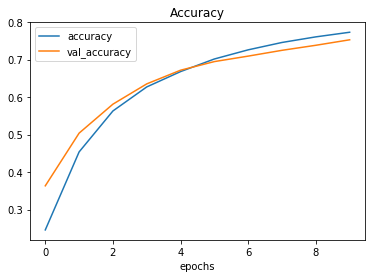

In [11]:
import matplotlib.pyplot as plt
x = range(0, len(history.accuracy_history))
plt.plot(x, history.accuracy_history)
plt.plot(x, history.val_accuracy_history)
plt.xlabel('epochs')
plt.title('Accuracy')
plt.legend(['accuracy', 'val_accuracy'])

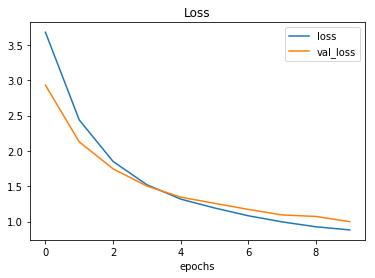

In [12]:
x = range(0, len(history.loss_history))
plt.plot(x, history.loss_history)
plt.plot(x, history.val_loss_history)
plt.xlabel('epochs')
plt.title('Loss')
plt.legend(['loss', 'val_loss'])